## This notebook 

uses a 1d model (**assume no advection**) to test **how long it takes** for the model to smooth the observed Th profile in Canada Basin, 2009.

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')



In [2]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import copy,os,glob
import pandas as pd
import seaborn as sn
import pylab
% matplotlib inline

In [3]:
# prepare key variables from model

mesh=nc.Dataset('/ocean/xiaoxiny/research/NEMO-code/NEMOGCM/CONFIG/myANHA/EXP00/mesh_files/mesh_mask_rm1Canada.nc')

mbathy=mesh.variables['mbathy'][0,700,180]
gdept=mesh.variables['gdept'][0,:mbathy,700,180]
gdepw=mesh.variables['gdepw'][0,:mbathy,700,180]
e3t=mesh.variables['e3t'][0,:mbathy+1,700,180]
e3w=mesh.variables['e3w'][0,:mbathy+1,700,180]

grid=nc.Dataset('/ocean/xiaoxiny/research/result_jasper/min_ice/para60_no_intercept/EXH001/S_ANHA4-EXH001_1y_19910101_19931231_ptrc_T.nc')
dep=grid.variables['deptht'][:mbathy]
nav_lon=grid.variables['nav_lon'][:]
nav_lat=grid.variables['nav_lat'][:]
depmax=np.max(dep[:])

bath=nc.Dataset('/ocean/xiaoxiny/research/data/Jasper/ANHA4_bathy_etopo1_gebco1_smoothed_coast_corrected_mar10.nc')
bathy=bath.variables['Bathymetry'][:]

# load observation 
csv_filename=sorted(glob.glob('/ocean/xiaoxiny/research/data/total/T*.csv'))

# Interpolate observed profile onto model grid

In [4]:
# Allocate array for interpolate observed data to model grid
layer=np.empty([len(dep)])
NEMO_dep=np.empty([len(dep)])
Real_dep=np.empty([len(dep)])
lons=np.empty([len(dep)])
lats=np.empty([len(dep)])
z=np.empty([len(dep)])

The purple scatters are observations. I interpolated the measurement on the model grid. The blue line shows the interpolation result.

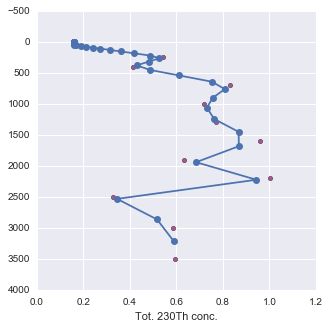

In [5]:
# load initial condition
# filename[5] is the file that contained the huge variation profile
for j in [5]: 
    data=pd.read_csv(csv_filename[j])
    x= data['depth'];
    y=data['230Th tot.'].values;

    x=np.ma.masked_where(y<=0,x)
    y=np.ma.masked_where(y<=0,y)

    x=x.compressed()
    y=y.compressed()

    
    xvals=dep
    yinterp2 = np.interp(xvals, x, y)
    
    fig = plt.figure(1,figsize=(5,5))
    plt.scatter(y,x, c=plt.cm.Set1(j*20))
    plt.plot(yinterp2,xvals,'-o')
plt.gca().invert_yaxis()
plt.xlabel('Tot. 230Th conc.')

In [6]:
# assume dissolved phase is 90% of the total / particulate phase is 10% of the total
xd=nc.Dataset('/ocean/xiaoxiny/research/data/init_files/newzero_ANHA_Pa_diss.nc')
xd=yinterp2*0.9

xp=nc.Dataset('/ocean/xiaoxiny/research/data/init_files/newzero_ANHA_Pa_part.nc')
xp=yinterp2*0.1

# Run 1d model

The biological productivity is high in Canada Basin. For this simplified model, I use 0% ice concentration to conduct the parameterization.

In [7]:
# Allocate array for 1d model
S = np.zeros(gdept.shape)
k_ad = np.zeros(gdept.shape)
I_init=np.zeros(gdept.shape)
I=np.copy(I_init)

Q = 0.0267     #dpm/m^3
k_de = 0.8     #desorption constants
ice = 0.0

# time info
t = 0.0
dt = 1./365/24/3600*10800
tmax = 30

# initialize the data 
xd_=np.copy(xd)
xp_=np.copy(xp)


anew=np.zeros(xd.shape)
bnew=np.zeros(xd.shape)
cnew=np.zeros(xd.shape)

In [8]:
sn.set()

The blue lines are the initial conditions. 

From the 1d model, we can see that it takes about 5 years to make the profiles smooth again. However, it takes **almost 30 years** for the profile to come back to the steady state.

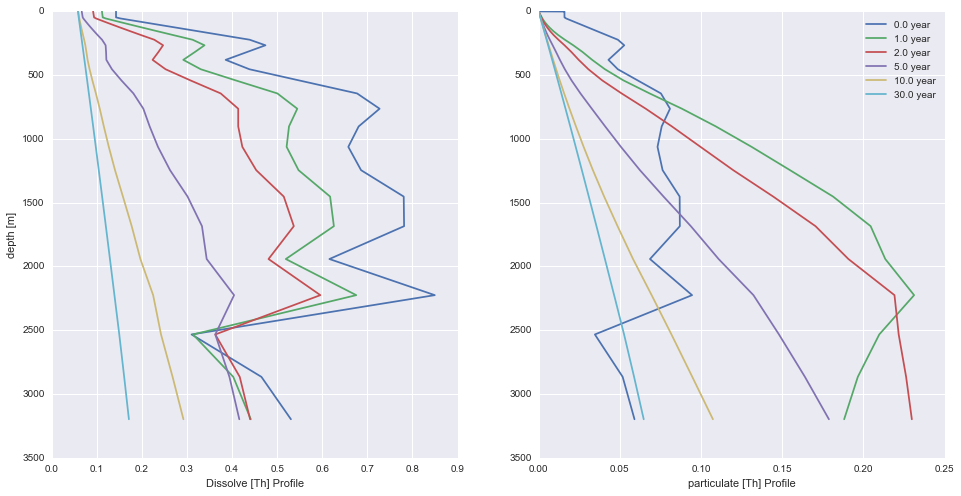

In [9]:
n=0
while (t < tmax):               # loop through all dt on [0, tmax]
    I[:16]=ice                  # ice/sinking rate/adsorption constants
    S[:] = -986.96*I[:]+1456.45
    k_ad[:] = -0.38*I[:]+0.46

    i=0                         # the surface BC.
    anew[i] = xd_[i] + (Q - k_ad[i]*xd_[i] + k_de*xp_[i]) * dt
    bnew[i] = 0.
    cnew[i] = I[i]   + (I[i-1]-I[i])*0.5*(S[i]+0)/e3w[i+1] * dt 
    
    i += 1
    while (i <= mbathy-1):     # loop through all depths
        
        # forward difference
        anew[i] = xd_[i] + (Q - k_ad[i]*xd_[i] + k_de*xp_[i]) * dt

        bnew[i] = xp_[i] + ((S[i-1]*xp_[i-1]-S[i]*xp_[i])/e3w[i+1] 
                  + k_ad[i]*xd_[i] - k_de*xp_[i]) * dt
        
        cnew[i] = I[i] + (I[i-1]-I[i])*0.5*(S[i]+S[i-1])/e3w[i+1] * dt
        
        i += 1

    # store the updated solution
    xd_[:] = anew[:]
    xp_[:] = bnew[:]
    I[:]   = cnew[:]

    t += dt


    if (n%(2920)==0) and (n/(2920.) in [0,1,2,5,10,30]):

            # final dissolved and particulate
            pylab.figure(2, figsize = (16, 8))
            pylab.subplot(121)
            pylab.plot(xd_, gdept,label='%s year'%(n/2920))
            pylab.subplot(122)
            pylab.plot(xp_, gdept,label='%s year'%(n/2920))
        
    n += 1

# label and scale plots
pylab.figure(2, figsize = (16, 8))
pylab.subplot(121)
pylab.ylabel('depth [m]')
pylab.xlabel('Dissolve [Th] Profile')
pylab.gca().invert_yaxis()

pylab.subplot(122)
pylab.xlabel('particulate [Th] Profile')
pylab.gca().invert_yaxis()
plt.legend()
